In [ ]:
import numpy as np, torch, time, os
from Ctubes.geometry_utils import compute_plane_normals, compute_cross_section_radii, regular_polygon
from Ctubes.plot_utils import plot_generatrix
from Ctubes.tubes import Directrix, Generatrix, CTube
from Ctubes.target_cross_sections import fix_end_cross_sections
from Ctubes.opt import CTubeOptimizationProblem
from Ctubes.misc_utils import load_curve_from_obj
from Ctubes.path_utils import get_name, setup_paths

paths = setup_paths(get_name())

PI = np.pi
TORCH_DTYPE = torch.float64
torch.set_default_dtype(TORCH_DTYPE)
torch.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

%matplotlib widget

# Figure 14: Klein Bottle

In [17]:
# Directrix: read curve from file
cps_ref = load_curve_from_obj(os.path.join(paths["data"], "fig14_klein_bottle/directrix_Q.obj"))
K = cps_ref.shape[0]
M = K

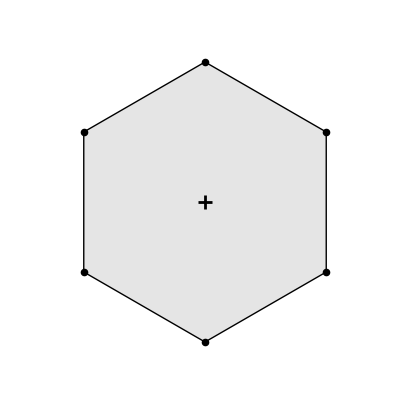

In [24]:
# Generatrix: regular N-gon
N = 6
tube_radius = 0.3
generatrix_2d = regular_polygon(N, tube_radius)

# Rotate by -90 degrees about the z axis
rotation_matrix = torch.tensor([[0.0, 1.0], [-1.0, 0.0]], dtype=TORCH_DTYPE)
generatrix_2d = (rotation_matrix @ generatrix_2d.T).T

fig, ax = plot_generatrix(generatrix_2d)

In [25]:
# C-tube
directrix = Directrix(cps_ref, M)
directrix.closed_curve = False  # avoid artifacts due to closure at cusp

X0 = directrix.X[0]
T0 = directrix.get_tangents()[0]
generatrix = Generatrix(generatrix_2d, X0, T0)

plane_normals_ref = compute_plane_normals(directrix.X, kind='bisecting', closed_curve=directrix.closed_curve)
z_axis = torch.tensor([0.0, 0.0, 1.0])
plane_normals_ref[0] = z_axis
plane_normals_ref[1] = z_axis
plane_normals_ref[-1] = -z_axis
plane_normals_ref[-2] = -z_axis

tube = CTube(directrix, generatrix, plane_normals_ref)

In [26]:
# Load target cross-section radii from file
target_cross_section_radii = torch.tensor(
    np.loadtxt(os.path.join(paths["data"], "fig14_klein_bottle/target_cross_section_radii.txt")), 
    dtype=TORCH_DTYPE
)

In [27]:
# Set init scale to match the target cross-section radius
curr_cs_radii = compute_cross_section_radii(tube.get_polyline(), tube.compute_vertices())
init_scale_ref = target_cross_section_radii[0] / curr_cs_radii[0]
tube.set_init_scale(init_scale_ref)
tube.update_ctube_vertices()

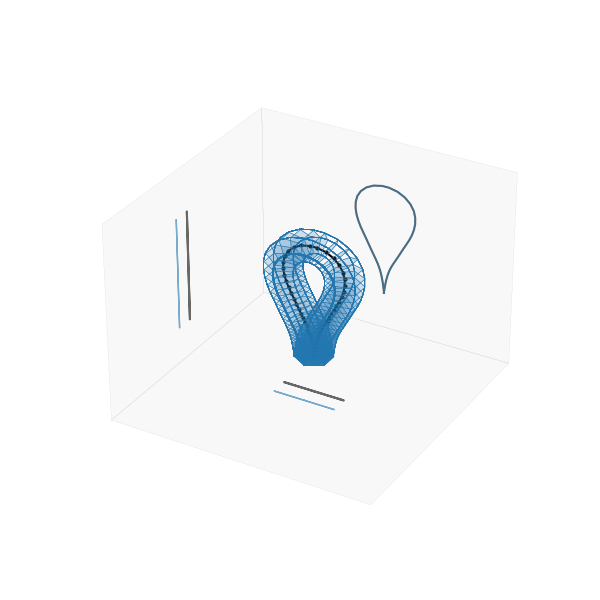

In [29]:
fig, ax = tube.plot_3d()

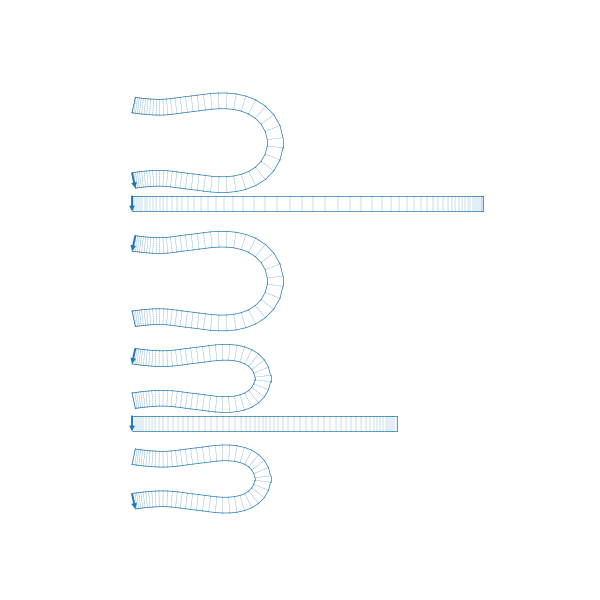

In [30]:
fig, ax = tube.plot_unrolled_strips()

### Optimization

In [34]:
# Set up optimization problem

opt_weights = {
    'match_target_cross_sections': 1e3 / generatrix.aabb_diagonal_length() ** 2,
    'match_target_cross_section_radius': 1e1 / generatrix.aabb_diagonal_length() ** 2,
    'smooth_tube_ridges': 1e2 / directrix.aabb_diagonal_length() ** 2,
    'smooth_plane_normal_diffs': 0e0,
    'smooth_apex_loc_func': 0e0,
}

objective_args = {
    'target_cross_sections': fix_end_cross_sections(tube),
    'target_cross_section_radii': target_cross_section_radii,
}

opt_prob = CTubeOptimizationProblem(
    tube, 
    opt_weights, 
    objective_args,
)

opt_prob.activate_cps(False)
opt_prob.activate_theta(False)
opt_prob.activate_apex_loc_func(True)
opt_prob.activate_plane_normals(True)

In [35]:
from scipy.optimize import minimize
from Ctubes.opt import obj_and_grad

torch.autograd.set_detect_anomaly(False)

# Set up optimization configuration
opt_prob.configure_optimization_output(paths)

# Get initial parameters
params0 = opt_prob.get_params_numpy()

# Define objective and gradient function for SciPy
obj_and_grad_scipy = lambda params: obj_and_grad(params, opt_prob)

# Fix variables via double-sided bounds
fixed_indices = []  # no fixed DOF by default
dofs = opt_prob.get_dof_indices_plane_normals()
fixed_indices += dofs[:6] + dofs[-6:]  # fix first two and last two plane normals
fixed_indices += [dofs[i] for i in range(1, 3*M - 1, 3)]  # fix y component of all plane normals

# dofs = opt_prob.get_dof_indices_apex_loc_func()
# fixed_indices += [dofs[0]] + [dofs[-1]]  # fix first and last apex loc func
fixed_indices = list(set(fixed_indices))  # remove duplicates
fixed_indices = sorted(fixed_indices)

bounds = [(None, None)] * len(params0)
for idx in fixed_indices:
    bounds[idx] = (params0[idx], params0[idx])
print(f"Fixing {len(fixed_indices)} parameters.")

# Add initial state to history
opt_prob.add_objective_to_history()

Fixing 72 parameters.


In [36]:
# Run optimization
start_time = time.time()
result = minimize(
    obj_and_grad_scipy, 
    params0, 
    jac=True, 
    method='L-BFGS-B',
    options={'ftol': 1.0e-10, 'gtol': 1.0e-5, 'disp': True, 'maxiter': 1000},
    bounds=bounds,
    callback=opt_prob.optimization_callback,
)
result.execution_time = time.time() - start_time

# Finalize optimization (save results, render videos, cleanup)
opt_prob.finalize_optimization(result)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          255     M =           10

At X0        72 variables are exactly at the bounds

At iterate    0    f=  2.67649D+00    |proj g|=  5.02612D+00

At iterate    1    f=  2.67436D+00    |proj g|=  3.60760D+00

At iterate    2    f=  2.65611D+00    |proj g|=  3.23103D+00

At iterate    3    f=  2.55297D+00    |proj g|=  8.67150D+00

At iterate    4    f=  2.36228D+00    |proj g|=  1.35389D+01

At iterate    5    f=  2.03097D+00    |proj g|=  1.84495D+01

At iterate    6    f=  1.82585D+00    |proj g|=  2.04729D+01

At iterate    7    f=  1.71776D+00    |proj g|=  7.05026D+00

At iterate    8    f=  1.69724D+00    |proj g|=  4.33667D+00

At iterate    9    f=  1.69435D+00    |proj g|=  1.95683D+00

At iterate   10    f=  1.69171D+00    |proj g|=  2.08920D+00

At iterate   11    f=  1.68496D+00    |proj g|=  3.58597D+00

At iterate   12    f=  1.66217D+00    |proj g|=  4.51739D+00

At iterate   13    f=  1.6

In [37]:
opt_prob.compute_objective(print_to_console=True)

match_target_cross_sections             : 0.0000357581
match_target_cross_section_radius       : 0.0058419230
smooth_tube_ridges                      : 0.0239643659
smooth_plane_normal_diffs               : 0.0000000000
smooth_apex_loc_func                    : 0.0000000000
preserve_tube_ridge_edge_directions     : 0.0030913989
unitary_plane_normals                   : 0.0000000007


tensor(0.0329)

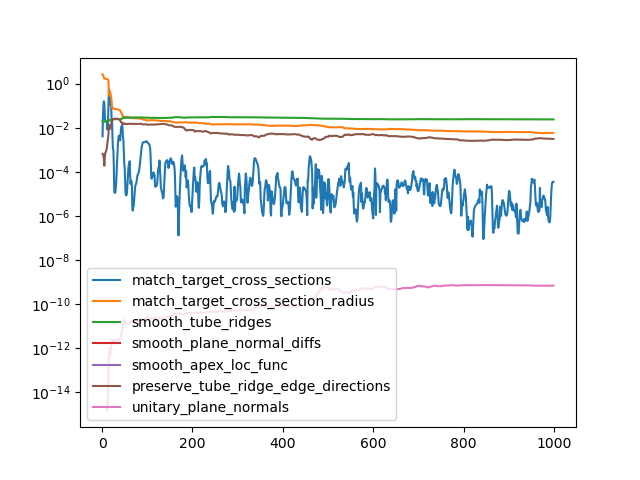

In [38]:
fig, ax = opt_prob.plot_objective_history()

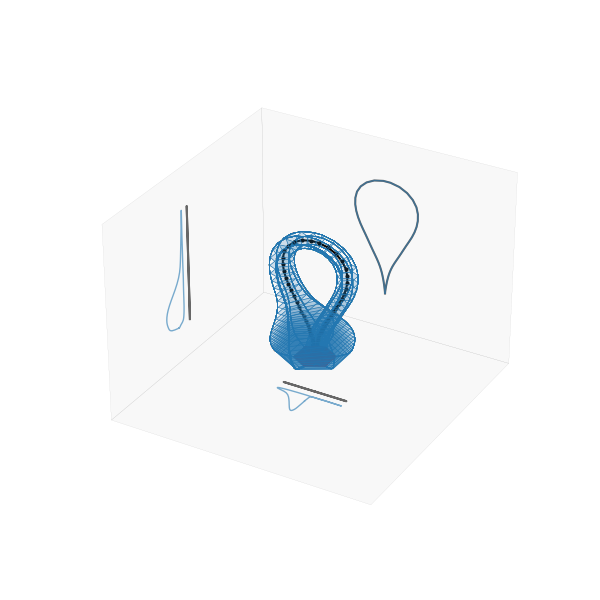

In [39]:
fig, ax = opt_prob.plot_3d()

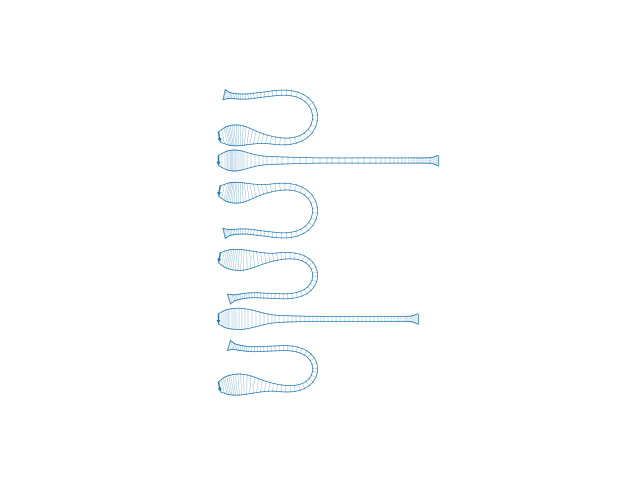

In [40]:
fig, ax = opt_prob.plot_unrolled_strips()

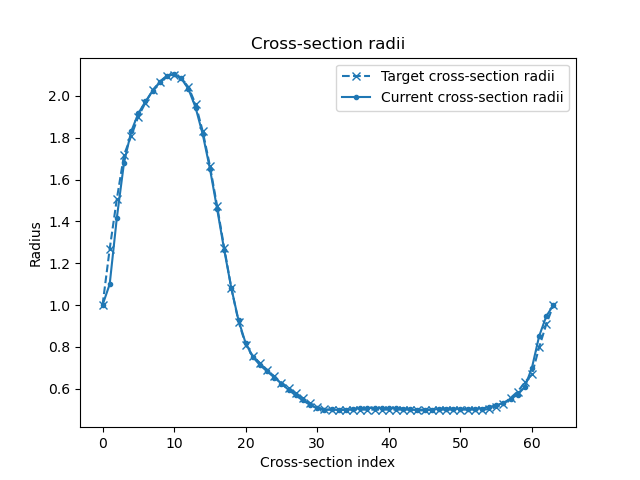

In [106]:
fig, ax = opt_prob.plot_cross_section_radii()

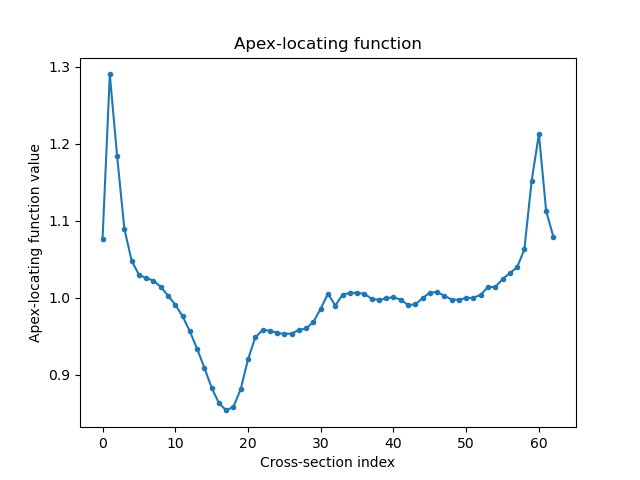

In [107]:
fig, ax = opt_prob.plot_apex_loc_func()